In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy
import os
from typing import Optional, Union
from __future__ import annotations
import math
from scipy import special
from math import log, e

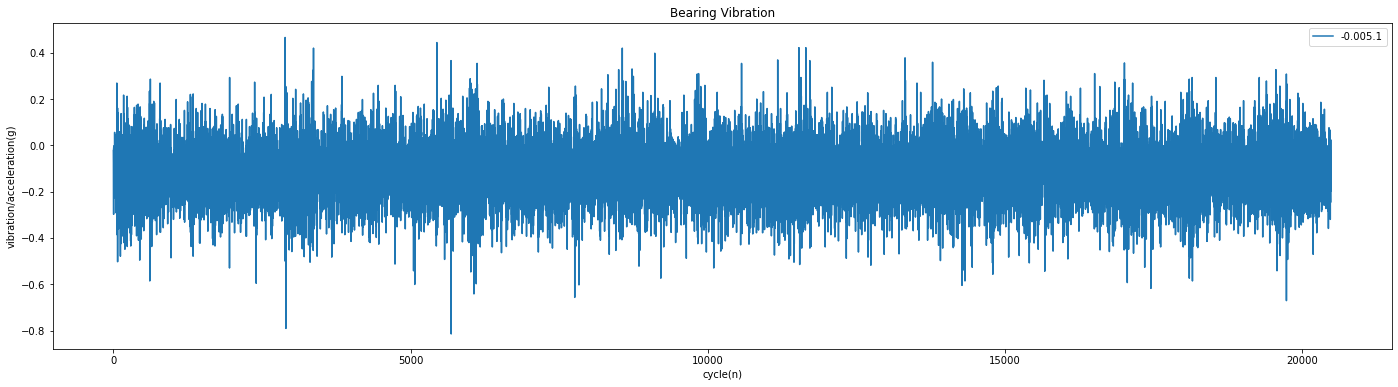

In [370]:
dataset = pd.read_csv('./1st_test/2003.11.14.15.32.17', sep='\t')
ax = dataset.iloc[:,5:6].plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()


In [92]:
dataset.iloc[:,5:6]

,-0.244
0,-0.249
1,-0.378
2,-0.291
3,-0.225
4,-0.051
...,...
20474,-0.178
20475,-0.232
20476,-0.039
20477,-0.222



In this section several signal-based statistical features has been extracted from the data                                 
**Definition and formula of the features:**
* ***Absolute Mean*** $$\overline{x} = \frac{1}{N}\sum_{i=1}^{N}|x_i| $$

* ***Standart Deviation:*** $$\sigma         = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(x_i - \overline{x})^2}$$
* ***Skewness:*** 
Asymmetry of a signal distribution. Faults can impact distribution symmetry and therefore increase the level of skewness.
$$\mathrm{Sk} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^3}{\sigma^3}$$
* ***Kurtosis:***
Length of the tails of a signal distribution, or equivalently, how outlier prone the signal is. Developing faults can increase the number of outliers, and therefore increase the value of the kurtosis metric. In essence it means how the tail of a distribution differ from the normal distributions. kurtosis identifies whether the tails of a given distribution contain extreme values
$$\mathrm{K} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^4}{\sigma^4}$$
* ***Entropy:***
is a measure of uncertainty of the probability distribution of the vibration signal
$$ H(X) = -\sum_{i=1}^{N} P(x_i)\log{P(x_i)} $$

where pxi are the probabilities computed from the distribution of x.
                            
* ***RMS:*** $$x_{rms} =\sqrt{(\frac{1}{N})\sum_{i=1}^{N}(x)^{2}}$$

* ***Peak to Peak:*** $$ x_p = \max \mathrm{value} - \min \mathrm{value}$$

* ***Crest Factor:*** 
Peak value divided by the RMS. Faults often first manifest themselves in changes in the peakiness of a signal before they manifest in the energy represented by the signal root mean squared. The crest factor can provide an early warning for faults when they first develop. is defined as the ratio of the peak amplitude value, xp, and the RMS amplitude
$$x_{crest} =\frac{\max \mathrm{value}}{\mathrm{x_{rms}}}$$

* ***Clearence Factor:*** 
Peak value divided by the squared mean value of the square roots of the absolute amplitudes. For rotating machinery, this feature is maximum for healthy bearings and goes on decreasing for defective ball, defective outer race, and defective inner race respectively. The clearance factor has the highest separation ability for defective inner race faults. is defined as the ratio of the maximum value of the input vibration signal to the mean square root of the absolute value of the input vibration
signal
$$ x_{clear} = \frac{x_p}{(\frac{1}{N}\sum_{i=1}^{N}\sqrt{|x_i|})^2}  $$

* ***Shape Factor:*** 
is defined as the ratio of the RMS value to the average of the absolute value of the vibration sign
$$\frac{x_{rms}}{\overline{x}}$$

* ***Impulse:*** 
Compare the height of a peak to the mean level of the signal.  is defined as the ratio of the peak value to the average of the
absolute value of the vibration signal
$$\frac{\max \mathrm{value}}{\overline{x}}  $$




In [8]:

def entropy(pk,
            qk: Optional[np.typing.ArrayLike] = None,
            base: Optional[float] = None,
            axis: int = 0
            ):
    """Calculate the entropy of a distribution for given probability values.
    If only probabilities `pk` are given, the entropy is calculated as
    ``S = -sum(pk * log(pk), axis=axis)``.
    If `qk` is not None, then compute the Kullback-Leibler divergence
    ``S = sum(pk * log(pk / qk), axis=axis)``.
    This routine will normalize `pk` and `qk` if they don't sum to 1.
    Parameters
    ----------
    pk : array_like
        Defines the (discrete) distribution. Along each axis-slice of ``pk``,
        element ``i`` is the  (possibly unnormalized) probability of event
        ``i``.
    qk : array_like, optional
        Sequence against which the relative entropy is computed. Should be in
        the same format as `pk`.
    base : float, optional
        The logarithmic base to use, defaults to ``e`` (natural logarithm).
    axis: int, optional
        The axis along which the entropy is calculated. Default is 0.
    Returns
    -------
    S : {float, array_like}
        The calculated entropy.
    Examples
    --------
    >>> from scipy.stats import entropy
    Bernoulli trial with different p.
    The outcome of a fair coin is the most uncertain:
    >>> entropy([1/2, 1/2], base=2)
    1.0
    The outcome of a biased coin is less uncertain:
    >>> entropy([9/10, 1/10], base=2)
    0.46899559358928117
    Relative entropy:
    >>> entropy([1/2, 1/2], qk=[9/10, 1/10])
    0.5108256237659907
    """
    if base is not None and base <= 0:
        raise ValueError("`base` must be a positive number or `None`.")

    pk = np.asarray(pk)
    pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
    if qk is None:
        vec = special.entr(pk)
    else:
        qk = np.asarray(qk)
        pk, qk = np.broadcast_arrays(pk, qk)
        qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)
        vec = special.rel_entr(pk, qk)
    S = np.sum(vec, axis=axis)
    if base is not None:
        S /= np.log(base)
    return S

In [3]:
# Root Mean Squared Sum
def get_rms(data):
    value = np.sqrt((data**2).sum() / len(data))
    rms_list = value
    return rms_list

# Peak to peak calculation
def calculate_p2p(df):
    return df.max().abs() + df.min().abs()

# extract shannon entropy (cut signals to 500 bins) Shannon's Entropy is simply the "amount of information" in a variable
def get_entropy(signal, base=None):
    vc = signal.value_counts(normalize=True, sort=False)
    base = e if base is None else base
    return -(vc * np.log(vc)/np.log(base)).sum()
# extract clearence factor
def calculate_clearence(df):
     
    result = ((np.sqrt(df.abs())).sum() / len(df))**2
    
    return result

In [4]:
directory_path = './1st_test'
dataframe = pd.DataFrame(columns=['mean','std','skewness','kurtosis','entropy','rms','max','peak_to_peak', 'crest', 'clearence', 'shape', 'impulse'])
for file in os.listdir(directory_path):
    file_data = pd.read_csv(os.path.join(directory_path, file),sep='\t')
    concerned_data = file_data.iloc[:,5:6]
    mean = np.array(concerned_data.abs().mean())[0]
    standard_deviation = np.array(concerned_data.std())[0]
    skewness = np.array(concerned_data.skew())[0]
    kurtosis = np.array(concerned_data.kurtosis())[0]
    entropy = get_entropy(concerned_data)
    rms = np.array(get_rms(concerned_data))[0]
    max_abs = np.array(concerned_data.abs().max())[0]
    peak_2_peak = calculate_p2p(concerned_data)[0]
    crest = max_abs/rms
    clearence = np.array(calculate_clearence(concerned_data))[0]
    shape = rms / mean
    impulse = max_abs / mean
    
    dataframe = dataframe.append({
        'mean':mean,
        'std':standard_deviation,
        'skewness':skewness,
        'kurtosis':kurtosis,
        'entropy':entropy,
        'rms':rms,
        'max':max_abs,
        'peak_to_peak':peak_2_peak,
        'crest':crest,
        'clearence':clearence,
        'shape':shape,
        'impulse':impulse
    },ignore_index=True)


dataframe

,mean,std,skewness,kurtosis,entropy,rms,max,peak_to_peak,crest,clearence,shape,impulse
0,0.108150,0.095490,-0.022286,0.777436,5.065897,0.131821,0.784,1.199,5.947458,0.093392,1.218868,7.249168
1,0.108458,0.094386,-0.028728,0.682840,5.057130,0.132052,0.576,0.993,4.361910,0.093646,1.217537,5.310789
2,0.109875,0.094055,0.019566,0.751218,5.051882,0.133295,0.620,0.984,4.651352,0.095119,1.213143,5.642756
3,0.110010,0.096508,-0.008438,0.667691,5.077825,0.133972,0.684,1.036,5.105532,0.094920,1.217818,6.217610
4,0.109350,0.095047,-0.024844,0.475547,5.066628,0.133282,0.623,1.055,4.674301,0.094207,1.218861,5.697322
...,...,...,...,...,...,...,...,...,...,...,...,...
2151,0.217346,0.258966,0.104428,2.306166,6.020837,0.283039,1.809,3.503,6.391336,0.180950,1.302255,8.323147
2152,0.330122,0.441049,0.051580,6.813490,6.480933,0.455034,5.000,8.884,10.988194,0.270239,1.378379,15.145899
2153,0.351640,0.477112,0.256820,6.755017,6.544869,0.490281,4.724,8.992,9.635290,0.286049,1.394270,13.434191
2154,0.335432,0.444306,0.104538,5.816830,6.498153,0.458873,4.089,7.568,8.910972,0.275450,1.368005,12.190257


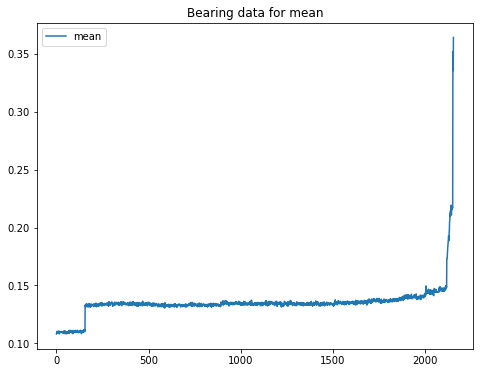

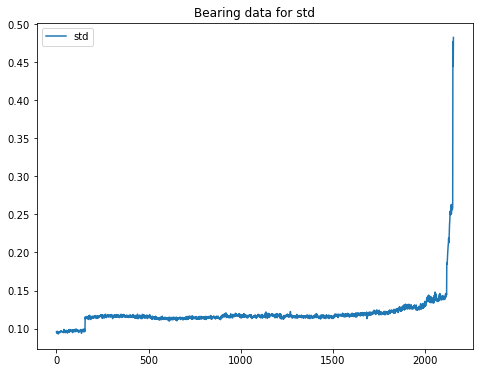

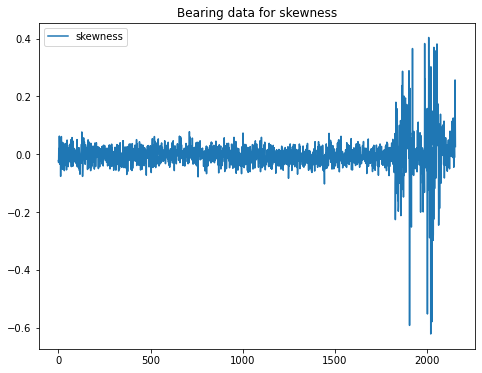

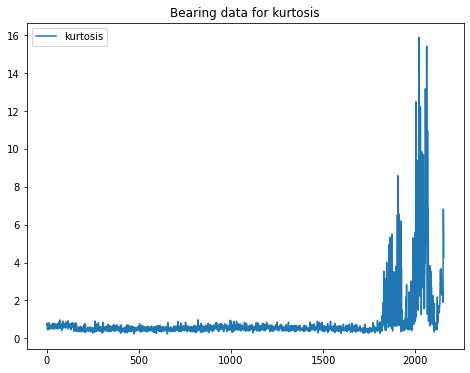

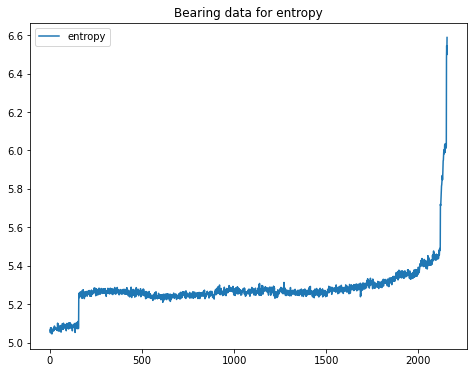

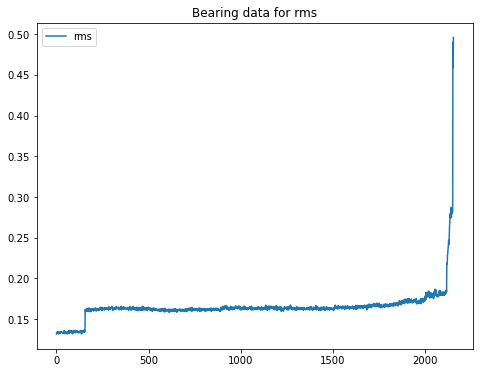

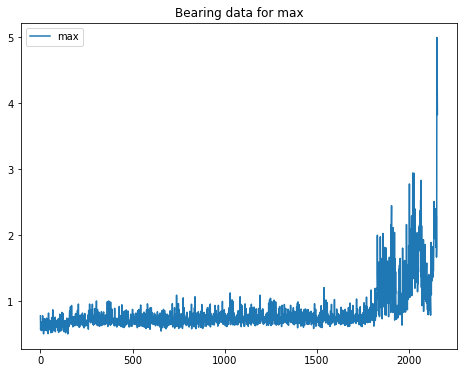

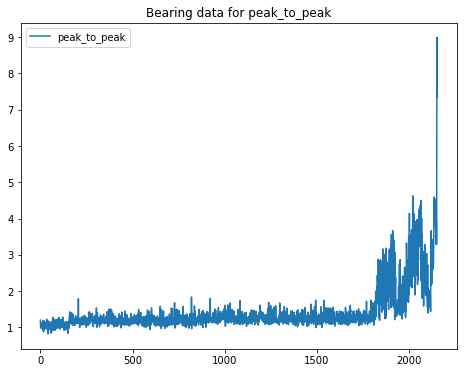

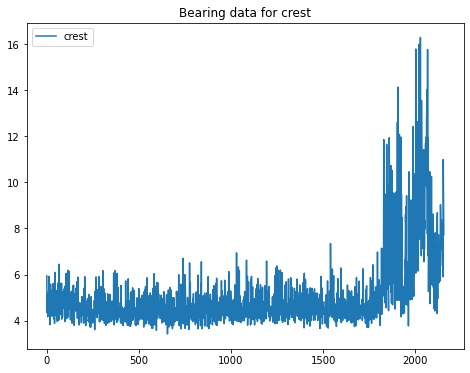

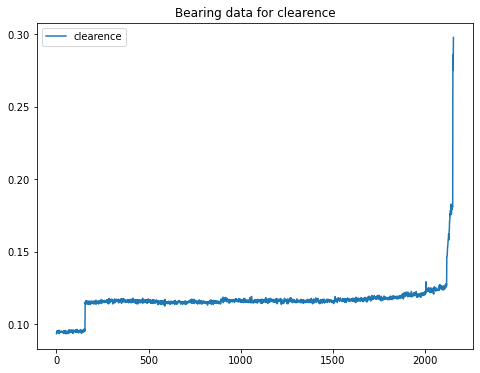

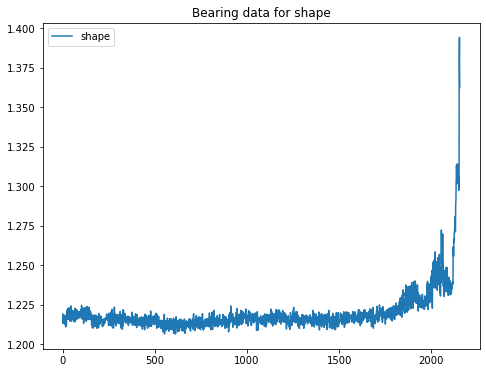

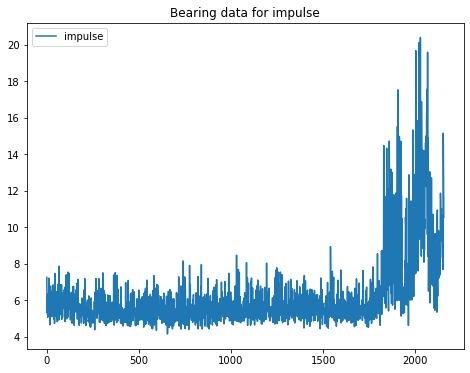

In [5]:
for col in dataframe:
    fig = plt.figure()
    ax1 = fig.add_subplot(141)
    dataframe[col].plot(figsize = (36,6), title="Bearing data for {}".format(col), legend = True ,axes=ax1)

In [278]:
array=[]
ones_array=list(np.ones(20))
zeros_array=list(np.zeros(66))


In [366]:
ideal_array = []
for i in range(0,233):
    ideal_array.extend(ones_array)
    if i%2==0:
        ideal_array.extend(list(np.zeros(66)))
    else:
        ideal_array.extend(list(np.zeros(67)))
    if i==235:
        ideal_array.extend(ones_array)

np.array(ideal_array)
len(ideal_array)
# 

20154

In [367]:
b4x = np.array(dataset.iloc[:,5:6])
b4x =  [i[0] for i in b4x]
np.array(b4x)

len(b4x)

20479

0.0028045549270616296

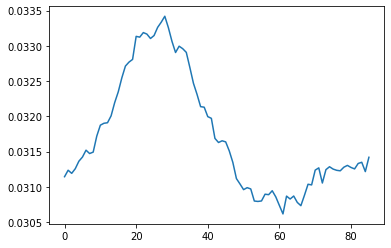

In [368]:
mean = []
for i in range(0,86):
    mean.append(abs(np.multiply(b4x[(i*1):len(ideal_array)+(i*1)], ideal_array)).mean())
    
plt.plot(mean)
max(mean)-min(mean)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


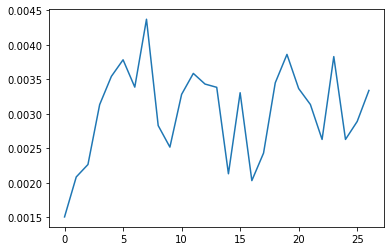

In [148]:
# fig, axs = plt.subplots(14,1)
new_directory_path = './1st_test/bleh'
diff = []
for n, file in enumerate(os.listdir(new_directory_path)):
    print(n)
    file_data = pd.read_csv(os.path.join(new_directory_path, file),sep='\t')
    concerned_data = file_data.iloc[:,5:6]
    b4x = np.array(concerned_data)
    b4x =  [i[0] for i in b4x]
# len(b4x)
    np.array(b4x)
    mean = []
    for i in range(0,86):
        mean.append(abs(np.multiply(b4x[(i):len(ideal_array)+(i)], ideal_array)).mean())
    
    diff.append(max(mean)-min(mean))
    
plt.plot(diff)